In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 21.4 MB/s 
     |████████████████████████████████| 86 kB 5.6 MB/s 
     |████████████████████████████████| 6.6 MB 55.3 MB/s 
     |████████████████████████████████| 596 kB 58.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install sklearn_crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 965 kB 39.7 MB/s 


In [3]:
!pip install -U 'scikit-learn<0.24'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.8 MB 24.9 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


In [4]:
! pip install pytorch-crf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import os
import pandas as pd
import re
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torchcrf import CRF
from transformers import BertTokenizer, BertTokenizerFast, Trainer, TrainingArguments, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import BertPreTrainedModel, BertModel
from transformers.modeling_outputs import TokenClassifierOutput
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
from transformers.trainer_utils import IntervalStrategy

In [6]:
tokens_data = pd.read_csv('train_tokens.csv', dtype={'sent_index': str, 'token': str, 'tag': str}, sep=';')
tokens_data_test = pd.read_csv('test_tokens.csv', dtype={'sent_index': str, 'token': str, 'tag': str}, sep=';')
tokens_data_eval = pd.read_csv('eval_tokens.csv', dtype={'sent_index': str, 'token': str, 'tag': str}, sep=';')
sents_data = pd.read_csv('train_sents.csv', dtype={'sent_index': str, 'sent_text': str, 'def': str}, sep=';')
sents_data_test = pd.read_csv('test_sents.csv', dtype={'sent_index': str, 'sent_text': str, 'def': str}, sep=';')
sents_data_eval = pd.read_csv('eval_sents.csv', dtype={'sent_index': str, 'sent_text': str, 'has_def': str}, sep=';')

In [7]:
def enrich_tokens_data(tokens_df, sents_df):
    tags = []
    for row in tokens_df.itertuples():
        small_d = sents_df.loc[sents_df['sent_index'] == row.sent_index]
        tags.append(str((list(small_d['has_def']))[0]))
    return tags

In [8]:
tokens_data['sent_has_def'] = enrich_tokens_data(tokens_data, sents_data)
tokens_data_test['sent_has_def'] = enrich_tokens_data(tokens_data_test, sents_data_test)
tokens_data_eval['sent_has_def'] = enrich_tokens_data(tokens_data_eval, sents_data_eval)

In [9]:
PRE_TRAINED_MODEL_NAME = "DeepPavlov/rubert-base-cased"

In [12]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

In [13]:
def bert_style_tokenize(df):
    tokens = []
    tags = []
    masks = []
    sents_tagrets = []
    for ind in set(list(df['sent_index'])):
        tokens_sent = []
        tags_sent = []
        masks_sent = []
        tokens_list = list(df.loc[df.sent_index == ind]['token'])
        tags_list = list(df.loc[df.sent_index == ind]['tag'])
        for i, t in enumerate(tokens_list):
            bert_t = tokenizer.tokenize(t)
            mask = []
            tag_t = []
            tag_t.append(tags_list[i])
            mask.append(1)
            tag_t.extend(['X' for i in range(len(bert_t)-1)])
            mask.extend([0 for i in range(len(bert_t)-1)])
            tokens_sent.extend(bert_t)
            masks_sent.extend(mask)
            tags_sent.extend(tag_t)
        sents_tagrets.append(list(df.loc[df.sent_index == ind]['sent_has_def'])[0])
        tokens.append(tokens_sent)
        tags.append(tags_sent)
        masks.append(masks_sent)
    return tokens, tags, masks, sents_tagrets

bert_tokens_train, bert_tags_train, masks_train, sents_tagrets_train = bert_style_tokenize(tokens_data)
bert_tokens_test, bert_tags_test, masks_test, sents_tagrets_test = bert_style_tokenize(tokens_data_test)
bert_tokens_eval, bert_tags_eval, masks_eval, sents_tagrets_eval = bert_style_tokenize(tokens_data_eval)

In [14]:
# for t, m, l, k in zip(sents_tagrets_train[:5], masks_train[:5], bert_tags_train[:5], bert_tokens_train[:5]):
#     print(t, m, l, k)

In [15]:
MAX_LEN = 128
tags_2id = {'B-TERM':0, 'I-TERM':1, 'B-DEF':2, 'I-DEF':3, 'O':4, 'X': 5}

In [16]:
class TokensDataset(torch.utils.data.Dataset):

    def __init__(self, bert_tokens, bert_tags, masks, sent_targets, tokenizer, MAX_LEN):
        self.bert_tokens = bert_tokens
        self.bert_tags = bert_tags
        self.masks = masks
        self.sent_targets = sent_targets
        self.tokenizer = tokenizer
        self.MAX_LEN = MAX_LEN
  
    def __getitem__(self, idx):
        tokens = self.bert_tokens[idx][:]
        tags = self.bert_tags[idx][:]
        masks_id = self.masks[idx][:]
        tags = ['X'] + tags + ['X']
        masks_id = [0]+masks_id+[0]
        tags = [tags_2id[i] for i in tags]
        tokens.append('SEP')
        tokens = ['CLS'] + tokens
        tokens2ids = tokenizer.convert_tokens_to_ids(tokens)
        tokens_mask = [1 for i in range(len(tokens2ids))]
        if len(tokens)>self.MAX_LEN:
            tokens2ids = tokens2ids[:self.MAX_LEN]
            tags = tags[:self.MAX_LEN]
            masks_id = masks_id[:self.MAX_LEN]
            tokens_mask = tokens_mask[:self.MAX_LEN]
        else:
            tokens2ids.extend([0 for i in range(MAX_LEN-len(tokens2ids))])
            tags.extend([tags_2id['X'] for i in range(MAX_LEN-len(tags))])
            masks_id.extend([0 for i in range(MAX_LEN-len(masks_id))])
            tokens_mask.extend([0 for i in range(MAX_LEN-len(tokens_mask))])
        return {
            'ids': torch.tensor(tokens2ids, dtype=torch.long),
            'targets': torch.tensor(tags, dtype=torch.long),
            'crf_masks': torch.tensor(masks_id).bool(),
            'bert_masks': torch.tensor(tokens_mask).bool(),
            'sent_targets': [int(self.sent_targets[idx])]*self.MAX_LEN
        }

    def __len__(self):
        return len(self.bert_tokens)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
train_dataset = TokensDataset(bert_tokens_train, bert_tags_train, masks_train, sents_tagrets_train, tokenizer, MAX_LEN)
test_dataset = TokensDataset(bert_tokens_test, bert_tags_test, masks_test, sents_tagrets_test, tokenizer, MAX_LEN)
eval_dataset = TokensDataset(bert_tokens_eval, bert_tags_eval, masks_eval, sents_tagrets_eval, tokenizer, MAX_LEN)

In [19]:
train_data_loader = DataLoader(train_dataset, 16)
test_data_loader = DataLoader(test_dataset, 16)
eval_data_loader = DataLoader(eval_dataset, 16)

In [20]:
# next(iter(train_data_loader))

In [21]:
lossBin = nn.BCEWithLogitsLoss()

In [38]:
class BinaryHead(nn.Module):

    def __init__(self, hidden_size):
        super().__init__()
        self.classifier = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input_embeds):
        cls_token = input_embeds[0][:,0]
        cls_token = self.dropout(cls_token)
        class_logits = self.classifier(cls_token)
        return class_logits

    def predict(self, input_embeds):
        class_logits = self.forward(input_embeds)
        class_probs = self.sigmoid(class_logits)
        return class_probs

In [39]:
class CRFHead(nn.Module):

    def __init__(self, num_labels, hidden_dropout_prob, hidden_size):
        super().__init__()
        self.num_labels = num_labels
        self.dropout = nn.Dropout(hidden_dropout_prob)
        self.classifier = nn.Linear(hidden_size, num_labels)
        self.crf = CRF(num_tags=num_labels, batch_first=True)

    def forward(
        self,
        input_embeds):

        sequence_output = input_embeds
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)
        return logits

    def loss(self, logits, labels, crf_masks):
        logits = logits[:,1:]
        labels = labels[:,1:]
        crf_masks = crf_masks[:,1:]
        log_likelihood = self.crf(logits, labels, mask=crf_masks)
        loss = 0 - log_likelihood
        return loss
    
    def predict(self, logits, crf_masks):
        logits = logits[:,1:]
        crf_masks = crf_masks[:,1:]
        tags = self.crf.decode(logits, mask=crf_masks)
        return tags

In [53]:
binaryHead = BinaryHead(768).to(device)
crfHead = CRFHead(6, 0.1, 768).to(device)
encoder = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME).to(device)
optimizer = optim.Adam(list(encoder.parameters())+list(binaryHead.parameters())+list(crfHead.parameters()), lr=0.0001)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
def train_epoch(data_loader, optimizer):
    binaryHead.train()
    encoder.train()
    crfHead.train()
    loss_epoch=0
    binary_loss_epoch=0
    crf_loss_epoch=0
    for d in data_loader:
        input_ids = d['ids'].to(device)
        targets = d['targets'].to(device)
        crf_masks = d['crf_masks'].to(device)
        bert_masks = d['bert_masks'].to(device)
        sent_targets = d['sent_targets'][0].view(bert_masks.shape[0],1).float().to(device)
        output = encoder(input_ids=input_ids,
                attention_mask=bert_masks)
        
        binary_logits = binaryHead(output)
        binary_loss = lossBin(binary_logits, sent_targets)
        binary_loss_epoch += binary_loss.item()
        
        sent_targets_list = d['sent_targets'][0]
        indexes = [i for i in range(len(sent_targets_list)) if sent_targets_list[i]==1]
        crf_inputs = torch.index_select(output[0], 0, torch.tensor(indexes, dtype=torch.long).to(device))
        targets = torch.index_select(targets, 0, torch.tensor(indexes, dtype=torch.long).to(device))
        crf_masks = torch.index_select(crf_masks, 0, torch.tensor(indexes, dtype=torch.long).to(device))

        crf_logits = crfHead(crf_inputs)
        crf_loss = crfHead.loss(crf_logits, targets, crf_masks)*0.001
        crf_loss_epoch += crf_loss.item()

        loss = crf_loss + binary_loss
        loss.backward()
        loss_epoch += loss.item()
        optimizer.step()
        optimizer.zero_grad()
    return binary_loss_epoch, crf_loss_epoch, loss_epoch

In [43]:
def evaluate(data_loader):
    binaryHead.eval()
    encoder.eval()
    crfHead.eval()
    loss_epoch=0
    binary_loss_epoch=0
    crf_loss_epoch=0
    targets_list = []
    preds = []
    bin_preds = []
    sent_targets_list = []
    for d in data_loader:
        input_ids = d['ids'].to(device)
        targets = d['targets'].to(device)
        crf_masks = d['crf_masks'].to(device)
        bert_masks = d['bert_masks'].to(device)
        sent_targets = d['sent_targets'][0].view(bert_masks.shape[0],1).float().to(device)
        output = encoder(input_ids=input_ids,
                attention_mask=bert_masks)
        
        binary_logits = binaryHead(output)
        binary_loss = lossBin(binary_logits, sent_targets)
        binary_preds = binaryHead.predict(output)
        binary_preds = torch.round(binary_preds)
        bin_preds.extend(binary_preds.tolist())
        sent_targets_list.extend(d['sent_targets'][0])

        sent_targets_crf_list = d['sent_targets'][0]
        indexes = [i for i in range(len(sent_targets_crf_list)) if sent_targets_crf_list[i]==1]
        crf_inputs = torch.index_select(output[0], 0, torch.tensor(indexes, dtype=torch.long).to(device))
        targets = torch.index_select(targets, 0, torch.tensor(indexes, dtype=torch.long).to(device))
        crf_masks = torch.index_select(crf_masks, 0, torch.tensor(indexes, dtype=torch.long).to(device))

        crf_logits = crfHead(crf_inputs)
        crf_preds = crfHead.predict(crf_logits, crf_masks)
        crf_preds = sum(crf_preds, [])
        preds.extend(crf_preds)

        crf_loss = crfHead.loss(crf_logits, targets, crf_masks)*0.001
        crf_loss_epoch += crf_loss.item()

        loss = binary_loss + crf_loss
        loss_epoch += loss.item()
        
        for i, sent_tar in enumerate(targets):
            targets_sent = [i for i in sent_tar.tolist() if i != 5]
            targets_list.extend(targets_sent)
        
    return binary_loss_epoch, crf_loss_epoch, loss_epoch, preds, targets_list, bin_preds, sent_targets_list

In [54]:
binary_losses = []
crf_losses = []
losses = []
eval_binary_losses = []
eval_crf_losses = []
eval_losses = []
for e in range(8):
    print(f'Epoch: {e}')
    binary_loss_epoch, crf_loss_epoch, loss_epoch = train_epoch(train_data_loader, optimizer)
    binary_losses.append(binary_loss_epoch)
    crf_losses.append(crf_loss_epoch)
    losses.append(loss_epoch)
    binary_loss_epoch, crf_loss_epoch, loss_epoch, preds, targets_list, bin_preds, sent_targets_list = evaluate(test_data_loader)
    eval_binary_losses.append(binary_loss_epoch)
    eval_crf_losses.append(crf_loss_epoch)
    eval_losses.append(loss_epoch)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7


In [55]:
import matplotlib.pyplot as plt
def plot_losses(losses, val_losses):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.title('Loss value')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

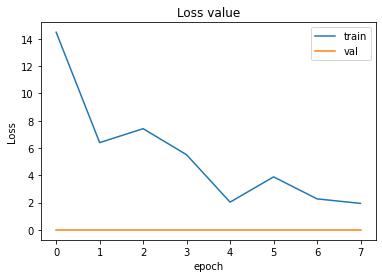

In [56]:
plot_losses(binary_losses, eval_binary_losses)

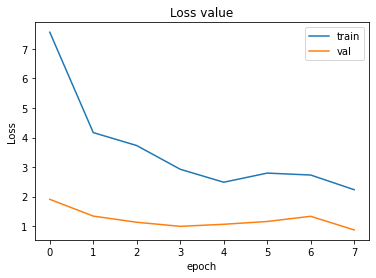

In [57]:
plot_losses(crf_losses, eval_crf_losses)

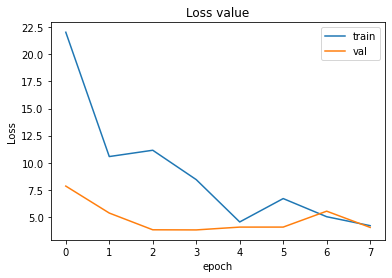

In [58]:
plot_losses(losses, eval_losses)

In [59]:
binary_loss_epoch, crf_loss_epoch, loss_epoch, preds, targets_list, bin_preds, sent_targets_list = evaluate(eval_data_loader)

In [60]:
print(classification_report(sent_targets_list, bin_preds, target_names=['no_def', 'has_def']))

              precision    recall  f1-score   support

      no_def       0.97      0.67      0.79        43
     has_def       0.77      0.98      0.86        49

    accuracy                           0.84        92
   macro avg       0.87      0.83      0.83        92
weighted avg       0.86      0.84      0.83        92



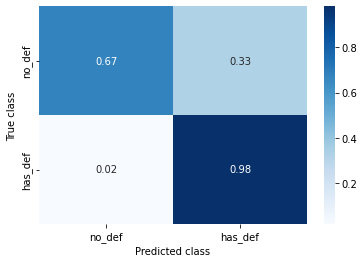

In [61]:
def show_confusion_matrix(confusion_matrix, class_names):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.ylabel('True class')
  plt.xlabel('Predicted class');

cm = confusion_matrix(sent_targets_list, bin_preds)
cmn = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
show_confusion_matrix(cmn, ["no_def", "has_def"])

In [62]:
print(classification_report(targets_list, preds, target_names=['B-TERM', 'I-TERM', 'B-DEF', 'I-DEF', 'O']))

              precision    recall  f1-score   support

      B-TERM       0.31      0.85      0.45        55
      I-TERM       0.36      0.30      0.33        50
       B-DEF       0.03      0.04      0.03        51
       I-DEF       0.84      0.81      0.83       936
           O       0.66      0.56      0.61       477

    accuracy                           0.69      1569
   macro avg       0.44      0.51      0.45      1569
weighted avg       0.73      0.69      0.70      1569



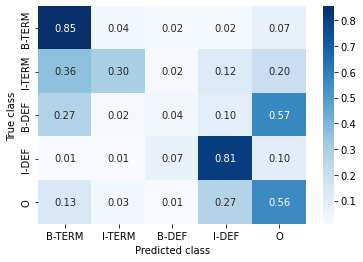

In [63]:
cm = confusion_matrix(targets_list, preds)
cmn = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
show_confusion_matrix(cmn, class_names=['B-TERM', 'I-TERM', 'B-DEF', 'I-DEF', 'O'])